In [92]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset

import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, ToGray

In [7]:
# define device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(device)

mps


In [6]:
# DOWNLOAD DATA 

# DOWNLOAD, RESIZE & NORMALIZE MNIST DATASET  (32x32x3 instead of originl 28x28x1)

from torchvision import datasets, transforms
import torch

# Define the transform to resize the image to 32x32 and replicate to 3 channels
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB by replicating channels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize each channel (assuming mean 0.5, std 0.5 for simplicity)
])

# Download and load the dataset with the defined transform
train_dataset_source = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset_source = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=True)

# DOWNLOAD, (RESIZE &) NORMALISE, SVHN DATASET (Stret View House Numbers)
train_dataset_target = datasets.SVHN(root='./svhn_data/', split='train', transform=transform, download=True) # transform to insure same shape and normalisation
test_dataset_target = datasets.SVHN(root='./svhn_data/', split='test', transform=transform, download=True)


Using downloaded and verified file: ./svhn_data/train_32x32.mat
Using downloaded and verified file: ./svhn_data/test_32x32.mat


In [8]:
# Extract labels
Ys_train = train_dataset_source.targets.clone().detach()
Ys_test = test_dataset_source.targets.clone().detach()
Yt_train = torch.tensor(train_dataset_target.labels)
Yt_test = torch.tensor(test_dataset_target.labels)

# Calculate weights for the loss function
# Source domain (MNIST)
label_count_source = torch.bincount(Ys_train) 
weights_source = len(Ys_train) /  label_count_source
print('source (MNIST) labels occurence:', label_count_source)
print('source distribution (%):',torch.round(label_count_source/len(Ys_train)*100,decimals = 0))

# Target domain (SVHN)
label_count_target = torch.bincount(Yt_train)
weights_target = len(Yt_train) / label_count_target
print('target (SVHN) labels occurence:', label_count_target)
print('target distribution (%):',torch.round(label_count_target/len(Yt_train)*100,decimals = 0))

source (MNIST) labels occurence: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
source distribution (%): tensor([10., 11., 10., 10., 10.,  9., 10., 10., 10., 10.])
target (SVHN) labels occurence: tensor([ 4948, 13861, 10585,  8497,  7458,  6882,  5727,  5595,  5045,  4659])
target distribution (%): tensor([ 7., 19., 14., 12., 10.,  9.,  8.,  8.,  7.,  6.])


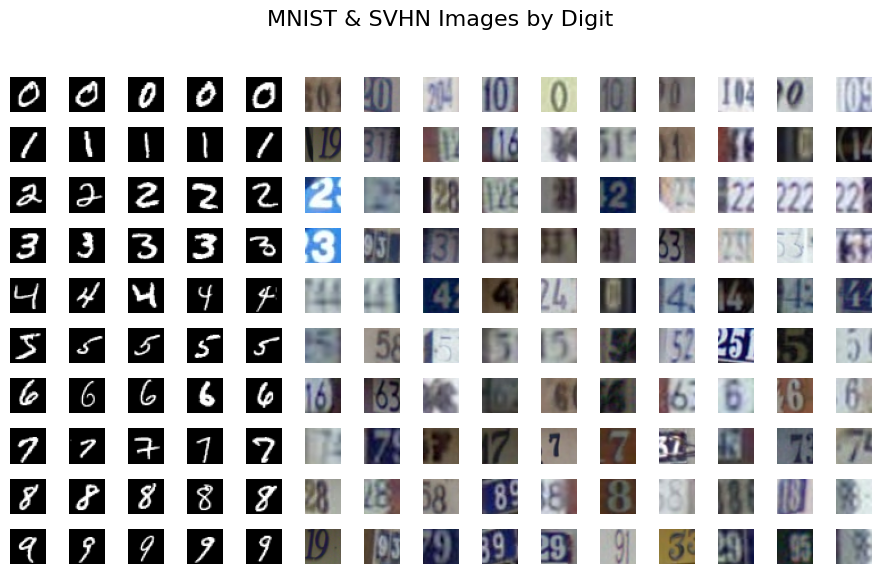

In [9]:
# Visualise numbers from each dataset (first row of 1 : 5 MNIST images of 1, 5 SVHN images of 1, etc.)
#----------------------------------------------------------------------------------------------------

# MNIST
fig, axs = plt.subplots(10, 15, figsize=(9, 6))

for i in range(10):
    
    #show 5 images with label i from MNIST
    idx = (Ys_train == i).nonzero()[:5].squeeze()
        
    for j, index in enumerate(idx):
        # Access and prepare image
        image = train_dataset_source.data[index]
        axs[i, j].imshow(image, cmap='gray')
        axs[i,j].axis('off')

    idx = (Yt_train == i).nonzero()[:10].squeeze()

    for j, index in enumerate(idx):
        # Access and prepare image
        image = train_dataset_target.data[index]
        image=image.transpose((1, 2, 0))
        axs[i, 5+j].imshow(image)
        axs[i,5+j].axis('off')
    
fig.suptitle('MNIST & SVHN Images by Digit', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



## Data Cleaninning

In [68]:
class CenterDigitsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, min_area=1000):
        self.dataset = dataset
        self.min_area = min_area
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]

        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        blurred = cv2.GaussianBlur(gray, (4, 4), 0)
        unsharp_mask = cv2.addWeighted(gray, 2, blurred, -1, 0)

        return unsharp_mask

In [73]:
def modify_data(image):
    image = np.moveaxis(image, 0, -1)
    image = (image * 255).astype(np.uint8)

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (4, 4), 0)
    unsharp_mask = cv2.addWeighted(gray, 2, blurred, -1, 0)

    return unsharp_mask

new_data = [modify_data(image) for image in train_dataset_target.data]

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/smooth.dispatch.cpp:294: error: (-215:Assertion failed) ksize.width > 0 && ksize.width % 2 == 1 && ksize.height > 0 && ksize.height % 2 == 1 in function 'createGaussianKernels'


In [69]:

centered_data = CenterDigitsDataset(train_dataset_target)
# train_loader = torch.utils.data.DataLoader(centered_svhn_train, batch_size=64, shuffle=True)

In [70]:
centered_data[0]

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

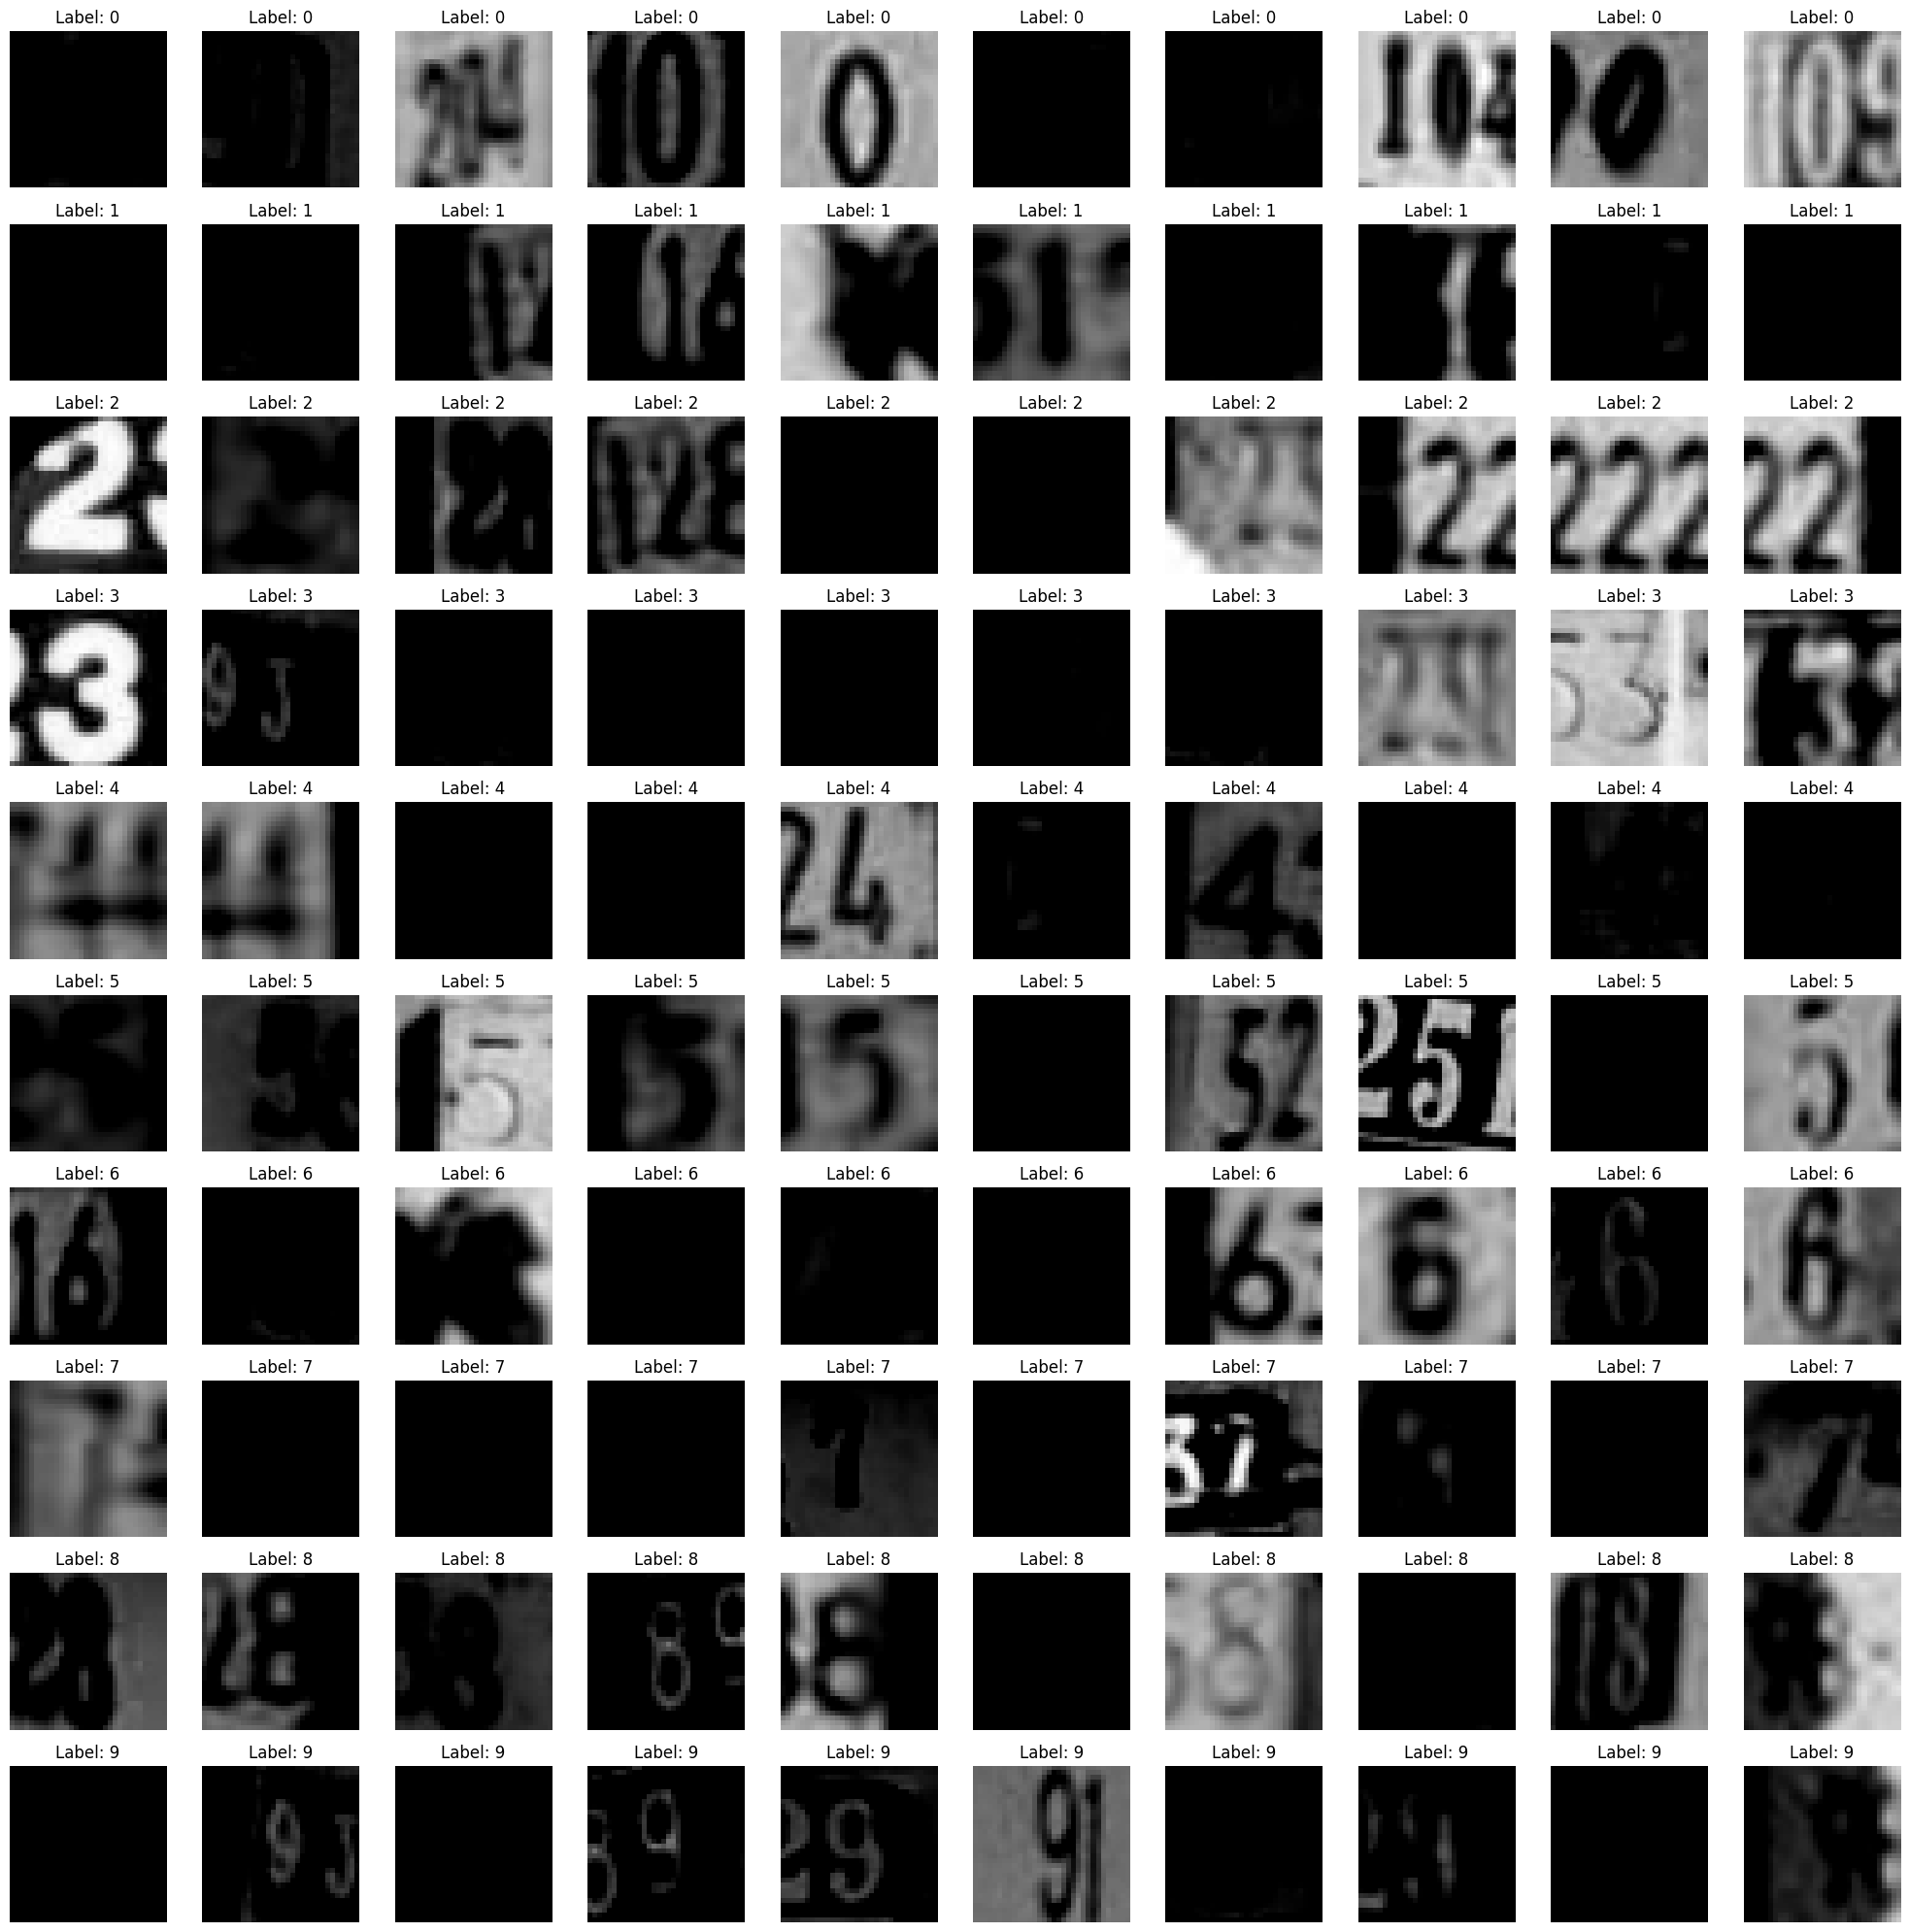

In [40]:
# Create a dictionary to store images grouped by label
grouped_images = {label: [] for label in range(10)}

# Collect images according to their labels
for image, label in train_dataset_target:
    grouped_images[label].append(image)

# Plot the images
num_rows = 10
num_cols = 10  # 10 images per label
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Iterate through labels and plot images
for i in range(num_rows):
    for j in range(num_cols):
        image = grouped_images[i][j] if j < len(grouped_images[i]) else None
        if image is not None:
            axs[i, j].imshow(image.permute(1, 2, 0))  # permute to (H, W, C) for visualization
            axs[i, j].set_title(f"Label: {i}")
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

TypeError: transpose() received an invalid combination of arguments - got (tuple), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


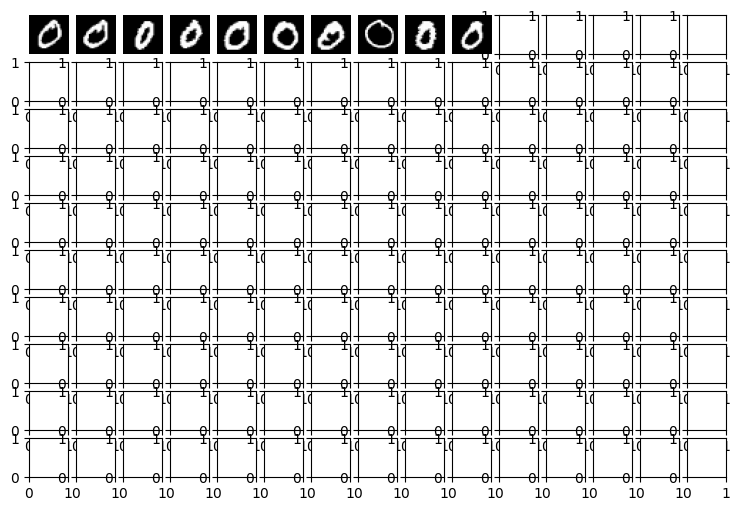

In [38]:
# Visualise numbers from each dataset (first row of 1 : 5 MNIST images of 1, 5 SVHN images of 1, etc.)
#----------------------------------------------------------------------------------------------------

# MNIST

centered_data = CenterDigitsDataset(train_dataset_target)
# train_loader = torch.utils.data.DataLoader(centered_svhn_train, batch_size=64, shuffle=True)


fig, axs = plt.subplots(10, 15, figsize=(9, 6))

for i in range(10):
    
    #show 5 images with label i from MNIST
    idx = (Ys_train == i).nonzero()[:10].squeeze()
        
    for j, index in enumerate(idx):
        # Access and prepare image
        image = train_dataset_source.data[index]
        axs[i, j].imshow(image, cmap='gray')
        axs[i,j].axis('off')

    idx = (Yt_train == i).nonzero()[:10].squeeze()

    for j, index in enumerate(idx):
        # Access and prepare image
        image = centered_data[index]
        image=image.transpose((1, 2, 0))
        axs[i, 5+j].imshow(image)
        axs[i,5+j].axis('off')
    
fig.suptitle('MNIST & SVHN Images by Digit', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB by replicating channels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize each channel (assuming mean 0.5, std 0.5 for simplicity)
])


In [67]:
class CleanSVHNDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, min_area=1000):
        self.dataset = dataset
        self.min_area = min_area
        self.transform = transforms.Compose([
            transforms.Resize((32, 32)),  # Resize to a fixed size
            transforms.Grayscale(num_output_channels=3),  # Convert to RGB by replicating channels
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize((0.5,), (0.5,))  # Normalize each channel
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]

        # Convert PIL image to numpy array
        image = Image.fromarray(image)

        # Convert the image to RGB if it has more than 3 channels
        if image.shape[2] > 3:
            image = image[:, :, :3]

        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Convert the grayscale image to 8-bit unsigned integer (CV_8U)
        gray = np.uint8(gray)

        # Threshold the image to obtain a binary image
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        # Find contours in the binary image
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to detect the digits
        digit_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > self.min_area]

        # Check if any digit contours were detected
        if not digit_contours:
            # Return original image if no digits were detected
            return self.transform(image)

        # Calculate the bounding boxes for the detected digits
        digit_boxes = [cv2.boundingRect(cnt) for cnt in digit_contours]

        # Calculate the center of each digit bounding box
        digit_centers = [(x + w//2, y + h//2) for x, y, w, h in digit_boxes]

        # Calculate the average center of all digits
        avg_center = np.mean(digit_centers, axis=0)

        # Calculate the offset required to center the digits in the image
        offset_x = image.shape[1] // 2 - avg_center[0]
        offset_y = image.shape[0] // 2 - avg_center[1]

        # Apply the offset to center the digits
        centered_image = np.zeros_like(image)
        for cnt in digit_contours:
            x, y, w, h = cv2.boundingRect(cnt)
            centered_cnt = cnt + np.array([offset_x, offset_y])
            cv2.drawContours(centered_image, [centered_cnt], 0, (255, 255, 255), thickness=cv2.FILLED)

        # Convert centered image back to PIL format
        centered_image_pil = cv2.cvtColor(centered_image, cv2.COLOR_BGR2RGB)
        centered_image_pil = transforms.ToPILImage()(centered_image_pil)

        # Apply the original transformations to the centered image
        centered_image_tensor = self.transform(centered_image_pil)

        return centered_image_tensor

clean_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL image
    # Add your cleaning transformations here
    transforms.Resize((32, 32)),  
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))
])
clean_svhn_data = [clean_transform(item) for item in train_dataset_target]
# Create CleanSVHNDataset with the clean_transform
clean_svhn_train = CleanSVHNDataset(clean_svhn_data)

TypeError: pic should be Tensor or ndarray. Got <class 'tuple'>.

array([[[ 33,  30,  38],
        [ 15,  23,  19],
        [ 15,  17,  19],
        ...,
        [ 72,  65,  56],
        [ 82,  77,  57],
        [ 89,  79,  59]],

       [[ 28,  39,  35],
        [ 14,  25,  22],
        [ 14,  20,  17],
        ...,
        [ 40,  39,  50],
        [ 67,  58,  52],
        [ 83,  78,  60]],

       [[ 40,  41,  38],
        [ 18,  21,  26],
        [ 16,  17,  23],
        ...,
        [ 23,  29,  45],
        [ 35,  42,  44],
        [ 72,  69,  53]],

       ...,

       [[ 86,  81,  75],
        [ 87,  82,  71],
        [ 82,  79,  65],
        ...,
        [104, 104,  87],
        [104, 105,  81],
        [103, 105,  78]],

       [[ 84,  86,  64],
        [ 86,  79,  72],
        [ 82,  76,  72],
        ...,
        [110, 103,  84],
        [106, 105,  85],
        [106, 104,  86]],

       [[ 85,  88,  68],
        [ 89,  82,  72],
        [ 85,  79,  67],
        ...,
        [111, 104,  87],
        [109, 105,  86],
        [103, 106,  79]]

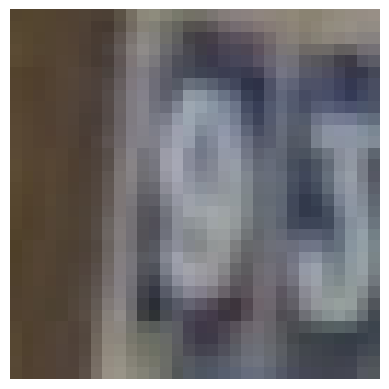

In [30]:
# train_dataset_target[0]

# image = train_dataset_target[0][0].permute(1, 2, 0).numpy()
image = train_dataset_target.data[6].transpose((1, 2, 0))
# Plot the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [26]:
train_dataset_target.data[45].shape

(3, 32, 32)

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/smooth.dispatch.cpp:294: error: (-215:Assertion failed) ksize.width > 0 && ksize.width % 2 == 1 && ksize.height > 0 && ksize.height % 2 == 1 in function 'createGaussianKernels'


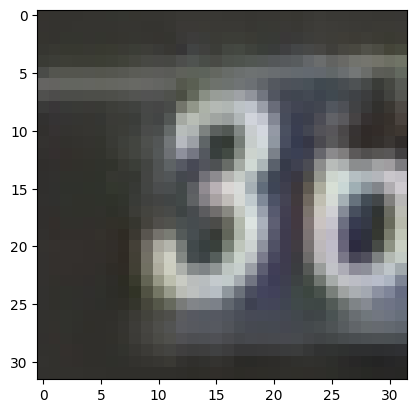

In [74]:
image = train_dataset_target.data[2444]
# image = Image.fromarray(image)
# print(image.shape)
image = np.moveaxis(image, 0, -1)

# Convert the image to uint8
image = (image * 255).astype(np.uint8)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Apply CLAHE to the grayscale image
clahe_image = clahe.apply(gray)

# Resize the CLAHE output to match the original image size
clahe_image_resized = cv2.resize(clahe_image, (image.shape[1], image.shape[0]))

clahe_image_resized = np.stack([clahe_image_resized] * 3, axis=-1)
plt.imshow(image)
kernel = np.ones((5,5), np.uint8)  # Define the kernel for morphological operations
# Erosion
erosion = cv2.erode(gray, kernel, iterations=1)
# Dilation
dilation = cv2.dilate(erosion, kernel, iterations=1)
# Opening
opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
# Closing
closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)


# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (4, 4), 0)

# Apply unsharp masking
unsharp_mask = cv2.addWeighted(gray, 2, blurred, -1, 0)

# Erosion
erosion = cv2.erode(unsharp_mask, kernel, iterations=1)
# Dilation
dilation = cv2.dilate(erosion, kernel, iterations=1)
# Opening
opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
# Closing
closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Apply CLAHE to the grayscale image
clahe_image = clahe.apply(unsharp_mask)

# Resize the CLAHE output to match the original image size
clahe_image_resized = cv2.resize(clahe_image, (image.shape[1], image.shape[0]))

clahe_image_resized = np.stack([clahe_image_resized] * 3, axis=-1)

# Apply Sobel operator in x and y directions
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

# Combine the gradients
sobel_combined = cv2.addWeighted(cv2.convertScaleAbs(sobel_x), 0.5, cv2.convertScaleAbs(sobel_y), 0.5, 0)

# Plot the original and processed images
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title('Original')

plt.subplot(2, 3, 2)
plt.imshow(erosion, cmap='gray')
plt.title('Erosion')

plt.subplot(2, 3, 3)
plt.imshow(dilation, cmap='gray')
plt.title('Dilation')

plt.subplot(2, 3, 4)
plt.imshow(sobel_combined, cmap='gray')
plt.title('sobel_combined')

plt.subplot(2, 3, 5)
plt.imshow(unsharp_mask, cmap='gray')
plt.title('unsharp_mask')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: Unexpected type <class 'numpy.ndarray'>

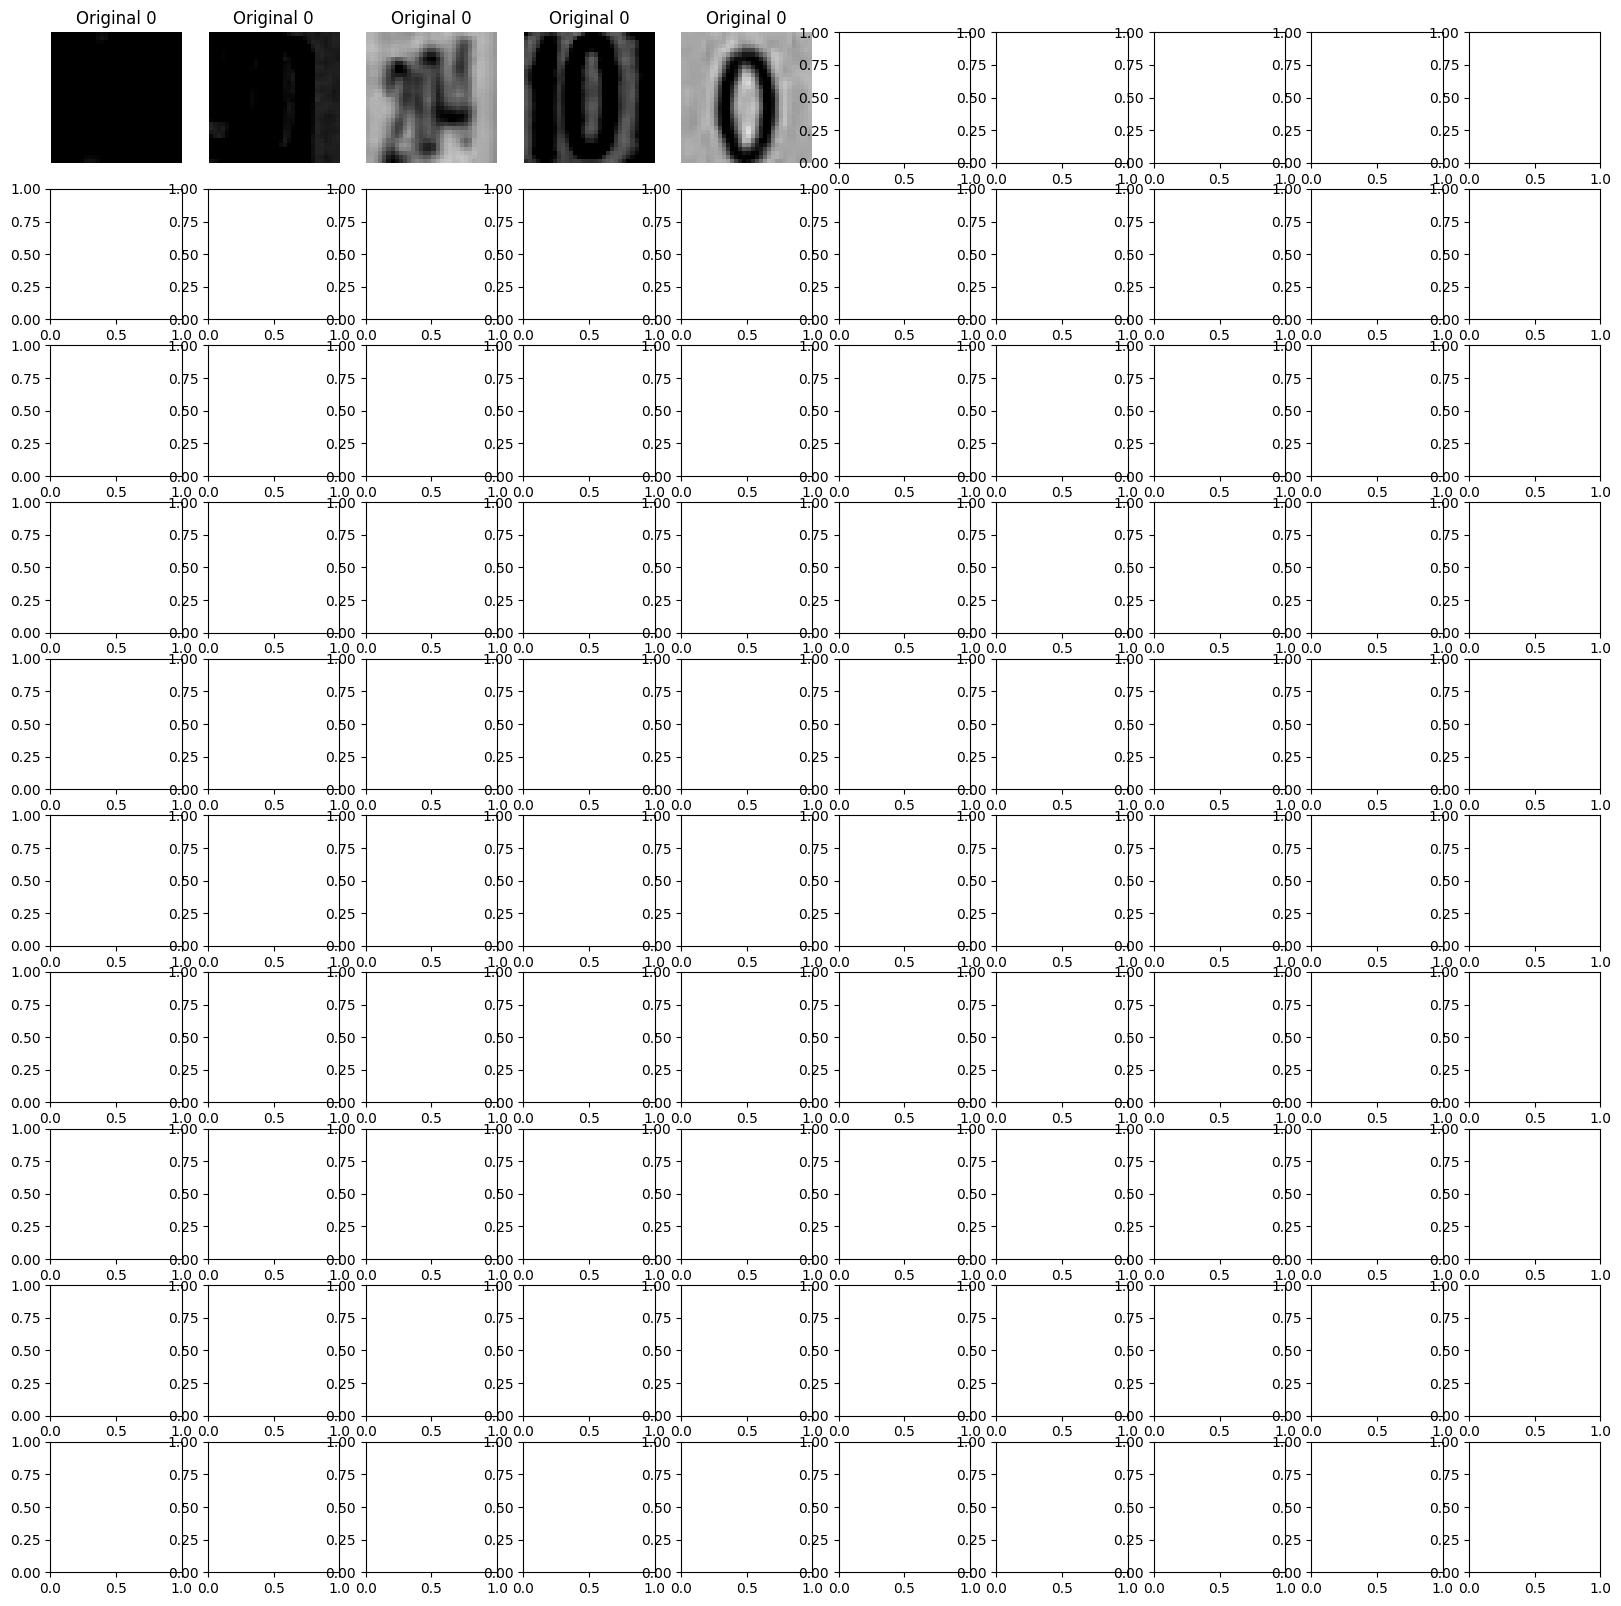

In [58]:
# Select a few samples per label
num_samples_per_label = 5

# Initialize plots
fig, axs = plt.subplots(10, num_samples_per_label*2, figsize=(num_samples_per_label*4, 20))

# Iterate through each label
for label in range(10):
    # Select random indices for the original dataset and cleaned dataset
    original_indices = np.where(train_dataset_target.labels == label)[0][:num_samples_per_label]
    clean_indices = np.where(clean_svhn_train.dataset.labels == label)[0][:num_samples_per_label]

    # Plot original samples
    for i, idx in enumerate(original_indices):
        axs[label, i].imshow(train_dataset_target[idx][0].permute(1, 2, 0))
        axs[label, i].set_title(f"Original {label}")
        axs[label, i].axis('off')

    # Plot cleaned samples
    for i, idx in enumerate(clean_indices):
        axs[label, num_samples_per_label + i].imshow(clean_svhn_train[idx].permute(1, 2, 0))
        axs[label, num_samples_per_label + i].set_title(f"Cleaned {label}")
        axs[label, num_samples_per_label + i].axis('off')

plt.tight_layout()
plt.show()

## Data Augmentation

In [185]:
def generate_rotation(image, param=10, number=16):
    aug_img = []
    rotate = A.Compose([A.Rotate(limit=param, p=1)])

    for i in range(number):
        to_add = torch.from_numpy(rotate(image=image.numpy())["image"])
        aug_img.append(to_add)

    return aug_img

def generate_gaussian_blur(image, param=0.5, number=16):
    aug_img = []
    gaussian_blur = A.Compose([A.GaussianBlur(p=param)])

    for i in range(number):
        to_add = torch.from_numpy(gaussian_blur(image=image.numpy())["image"])
        aug_img.append(to_add)

    return aug_img

def generate_brightness_contrast(image, param=0.5, number=16):
    aug_img = []
    brightness_contrast = A.Compose([A.RandomBrightnessContrast(p=param)])

    for i in range(number):
        to_add = torch.from_numpy(brightness_contrast(image=image.numpy())["image"])
        aug_img.append(to_add)

    return aug_img

In [191]:
def increase_data(dataset, number=10):
    all_samples = []
    all_labels = []

    for image, label in dataset:
        rotation_images = generate_rotation(image, number=number)
        gaussian_blur_images = generate_gaussian_blur(image, number=number)
        brightness_contrast_images = generate_brightness_contrast(image, number=number)

        all_samples.append(image)
        all_samples.extend(rotation_images)
        all_samples.extend(gaussian_blur_images)
        all_samples.extend(brightness_contrast_images)

        all_labels.append(label)
        all_labels.extend([label] * len(rotation_images))
        all_labels.extend([label] * len(gaussian_blur_images))
        all_labels.extend([label] * len(brightness_contrast_images))

    return all_samples, all_labels

In [193]:
new_data, new_labels = increase_data(train_dataset_source, 5)

In [198]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        return sample, label

train_dataset_source_augmented = CustomDataset(data=new_data, labels=new_labels)

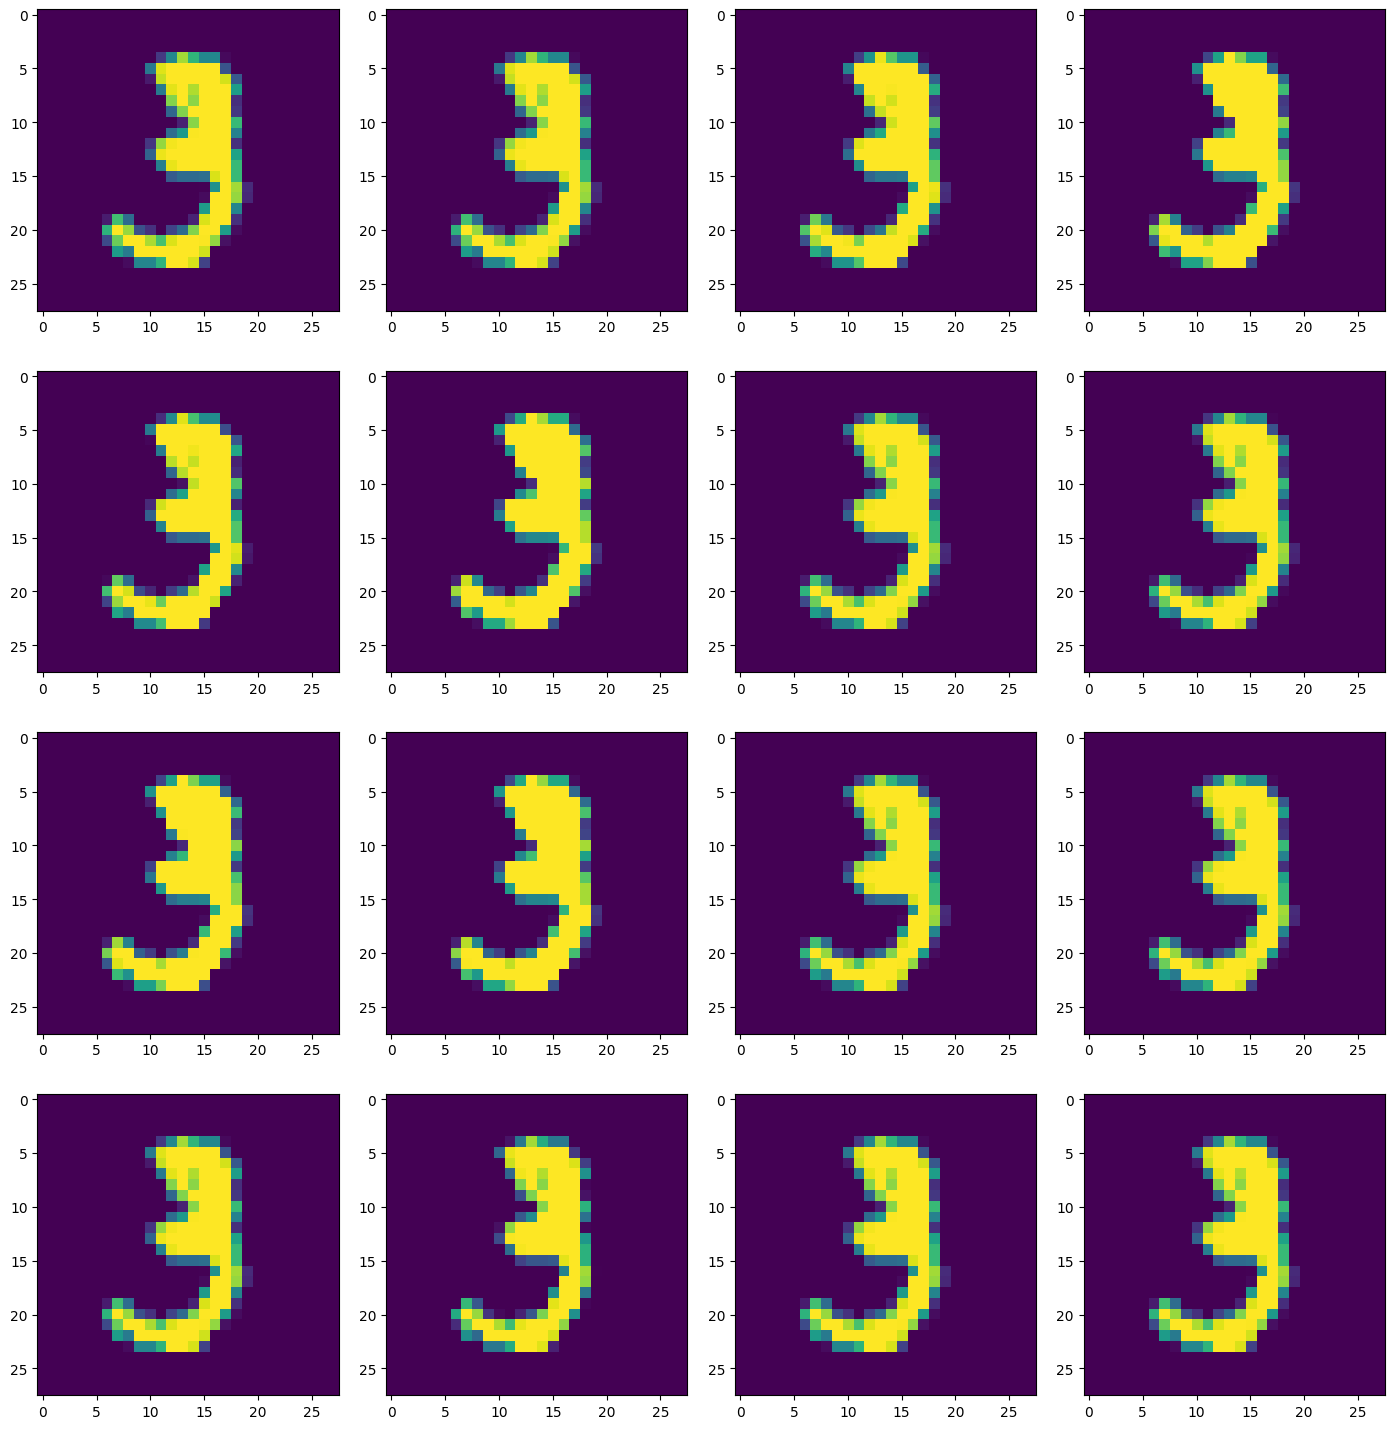

In [202]:
img = train_dataset_source.data[10].numpy()

aug = []
aug_img = []
param1 = (10)
rotate = A.Compose([A.RandomBrightnessContrast(p=0.5)])
for i in range(16):
    aug_img += [rotate(image=img)]

fig, ax = plt.subplots(4,4, figsize=(18,18))
plt.subplots_adjust(wspace=0)

for i in range(16):
    r=i//4
    c=i%4
    ax[r][c].imshow(aug_img[i]['image'])
    
plt.show()